In [1]:
from utils.load_data import *
import numpy as np

BCIC_dataset = load_BCIC(
train_sub=[1,2,3,4,5,6,7,8],
test_sub=[9],
alg_name = 'Tensor_CSPNet',
scenario = 'subject-independent'
)

train_x, train_y, test_x, test_y = BCIC_dataset.generate_training_valid_test_set_subject_independent()

In [300]:
train_x_normalized = np.zeros_like(train_x)

for i in range(train_x.shape[0]):
    tensor = train_x[i]
    l2_norm = np.linalg.norm(tensor)
    train_x_normalized[i] = tensor / l2_norm

data_x_0, data_y_0 = [], []
data_x_1, data_y_1 = [], []
data_x_2, data_y_2 = [], []
data_x_3, data_y_3 = [], []
data_x, data_y = [], []    

for idx, i in enumerate(train_y):
    lab = int(i)
    if lab == 0:
        data_x_0.append(train_x_normalized[idx])
        data_y_0.append(i)
    if lab == 1:
        data_x_1.append(train_x_normalized[idx])
        data_y_1.append(i)
    if lab == 2:
        data_x_2.append(train_x_normalized[idx])
        data_y_2.append(i)
    if lab == 3:
        data_x_3.append(train_x_normalized[idx])
        data_y_3.append(i)
    data_x.append(train_x_normalized[idx])
    data_y.append(i)

In [301]:
import torch 
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

class BCI_datset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx]).to(torch.float32), self.y[idx]
    
dataset0 = BCI_datset(data_x, data_y)
# dataset1 = BCI_datset(data_x_1, data_y_1)
# dataset2 = BCI_datset(data_x_2, data_y_2)
# dataset3 = BCI_datset(data_x_3, data_y_3)

dataloader0 = DataLoader(dataset0, batch_size=64, shuffle=True, num_workers=0)
# dataloader1 = DataLoader(dataset1, batch_size=32, shuffle=True, num_workers=1)
# dataloader2 = DataLoader(dataset2, batch_size=32, shuffle=True, num_workers=1)
# dataloader3 = DataLoader(dataset3, batch_size=32, shuffle=True, num_workers=1)


In [323]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from lib.sdes import VariancePreservingSDE, PluginReverseSDE
from lib.plotting import get_grid
from lib.flows.elemwise import LogitTransform
from lib.helpers import logging, create
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""  
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps."""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[...,None, None, None]


class ScoreNet(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """Initialize a time-dependent score-based network.

        Args:
          marginal_prob_std: A function that takes time t and gives the standard
            deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
          channels: The number of channels for feature maps of each resolution.
          embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()
        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
             nn.Linear(embed_dim, embed_dim))
        # Encoding layers where the resolution decreases
        self.conv1 = torch.nn.Conv3d(in_channels=2, out_channels=32, kernel_size=(3,18,18), padding=(0,0,0), bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(3,3,3), padding=(0,0,0), bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = torch.nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(3,2,2), padding=(0,0,0), bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = torch.nn.Conv3d(in_channels=128, out_channels=256, kernel_size=(3,1,1), padding=(0,0,0), bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

        # Decoding layers where the resolution increases
        self.tconv4 = torch.nn.ConvTranspose3d(in_channels=256, out_channels=128, kernel_size= (3,1,1), padding=(0,0,0), bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = torch.nn.ConvTranspose3d(in_channels=256, out_channels=64, kernel_size= (3,2,2), padding=(0,0,0), bias=False)    
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = torch.nn.ConvTranspose3d(in_channels=128, out_channels=32, kernel_size= (3,3,3), padding=(0,0,0), bias=False)   
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = torch.nn.ConvTranspose3d(in_channels=64, out_channels=2, kernel_size= (3,18,18), padding=(0,0,0), bias=False)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std
    def forward(self, x, t): 
        # Obtain the Gaussian random feature embedding for t   
        embed = self.act(self.embed(t))    
        # Encoding path
        h1 = self.conv1(x)    
        ## Incorporate information from t
        h1 += self.dense1(embed)
        ## Group normalization
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)
        # print(h1.shape)
        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        # print(h2.shape)
        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        # print(h3.shape)
        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)
        # print(h4.shape)
        # Decoding path
        h = self.tconv4(h4)
        ## Skip connection from the encoding path
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)
        h = self.tconv1(torch.cat([h, h1], dim=1))
        h = h / self.marginal_prob_std(t)[:, None, None, None, None]
        return h
    

In [324]:
import functools
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
    """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  

    Returns:
    The standard deviation.
    """    
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    """Compute the diffusion coefficient of our SDE.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The vector of diffusion coefficients.
    """
    return torch.tensor(sigma**t, device=device)
  
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models.

    Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
    """
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None, None, None, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None, None, None, None] + z)**2, dim=(1,2,3,4)))
    return loss

sigma =  0.1#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [325]:
import torch
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import tqdm.notebook as tqdm


score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs =   1000

lr=1e-4


optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.999 ** epoch)
tqdm_epoch = tqdm.tnrange(n_epochs)
losses = []

for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x, y in dataloader0:
        x = x.to(device)    
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        losses.append(avg_loss / num_items)
    scheduler.step()
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    # torch.save(score_model.state_dict(), 'ckpt.pth')


  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_19394/1243131229.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


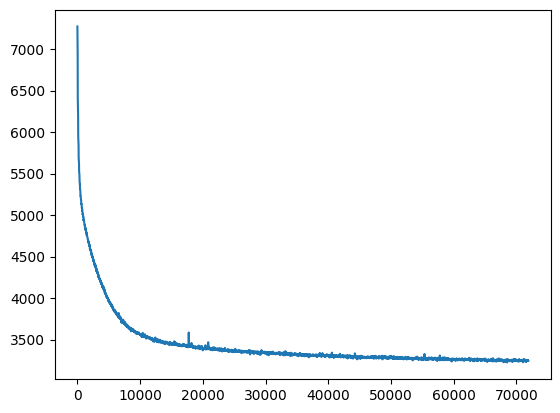

In [327]:
plt.plot(losses[100:])
plt.show()

In [328]:
from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5 #@param {'type': 'number'}
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64, 
                atol=error_tolerance, 
                rtol=error_tolerance, 
                device='cuda', 
                z=None,
                eps=1e-3):
    """Generate samples from score-based models with black-box ODE solvers.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation 
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
    """
    t = torch.ones(batch_size, device=device)
    # Create the latent code
    if z is None:
        init_x = torch.randn(batch_size, 2, 9, 22, 22, device=device) \
          * marginal_prob_std(t)[:, None, None, None, None]
    else:
        init_x = z
    
    shape = init_x.shape

    def score_eval_wrapper(sample, time_steps):
        """A wrapper of the score-based model for use by the ODE solver."""
        sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
        time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
        with torch.no_grad():    
            score = score_model(sample, time_steps)
        return score.cpu().numpy().reshape((-1,)).astype(np.float64)

    def ode_func(t, x):        
        """The ODE function for use by the ODE solver."""
        time_steps = np.ones((shape[0],)) * t    
        g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
        return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)

    # Run the black-box ODE solver.
    res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')  
    print(f"Number of function evaluations: {res.nfev}")
    x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

    return x

from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.
device = 'cuda' 

sample_batch_size = 64 
sampler = ode_sampler

## Generate samples using the specified sampler.
samples = sampler(score_model,
                marginal_prob_std_fn,
                diffusion_coeff_fn,
                batch_size=1, 
                atol=error_tolerance, 
                rtol=error_tolerance, 
                device='cuda', 
                z=None,
                eps=1e-3)


/tmp/ipykernel_19394/1243131229.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
/tmp/ipykernel_19394/1243131229.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


Number of function evaluations: 164


torch.Size([9, 22, 22])


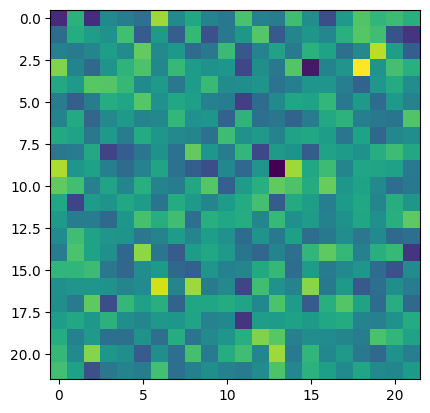

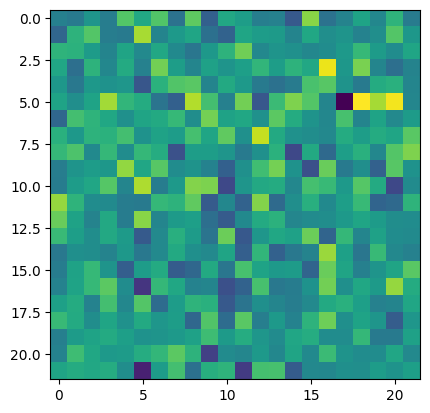

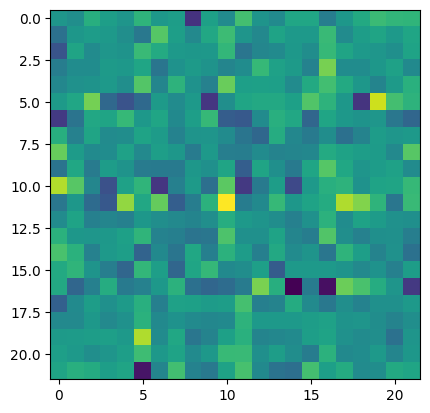

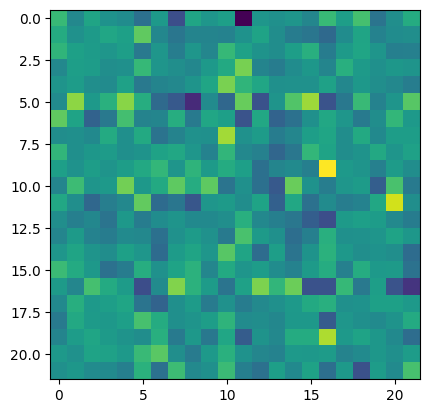

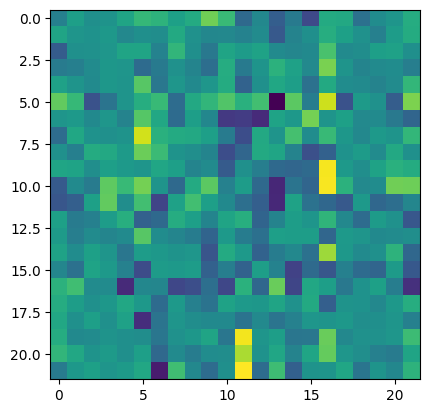

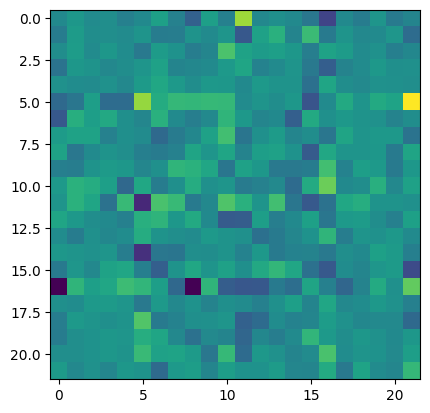

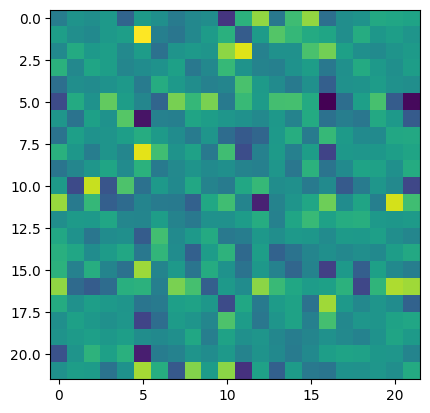

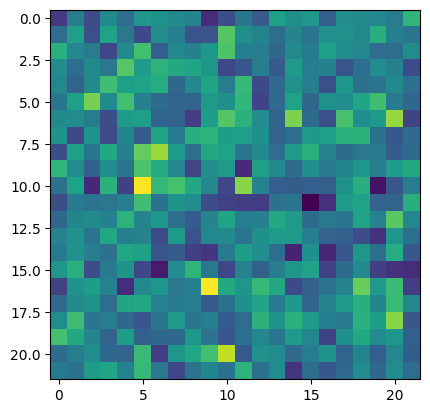

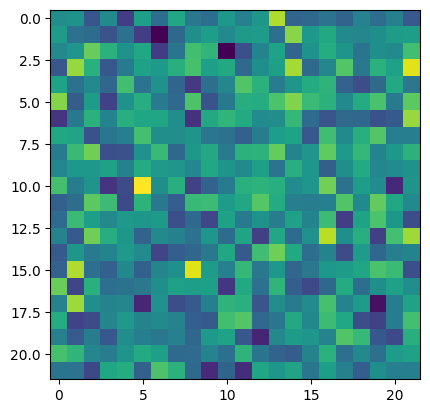

In [329]:
print(samples[0][0].shape)
data = samples[0][1]
for i in range(data.shape[0]):
    plt.imshow(data[i].cpu())
    plt.show()